# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras import backend as K

import cv2


### Helper functions

In [3]:
def build_model_normalization(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [4]:
def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [5]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [6]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [7]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

In [8]:
def preprocess_train(data, img_size_target):
    X_fin, y_fin = [], []
    video = data['video']
    frames = data['frames']
    label = data['label']
    h, w = video.shape[0], video.shape[1]
    X = video[:,:,frames]
    y = label[:,:,frames] * 1
    X = cv2.resize(X, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = cv2.resize(y, (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
    y = (y > 0) * 1.0
    for i in range(len(frames)):
        X_fin.append(X[:,:,i])
        y_fin.append(y[:,:,i])
    return X_fin, y_fin

In [9]:
def preprocess_test(data, img_size_target):
    X_fin = []
    video = data['video']
    for i in range(video.shape[2]):
        frame = cv2.resize(video[:,:,i], (img_size_target, img_size_target), interpolation = cv2.INTER_NEAREST)
        X_fin.append(frame)
    return X_fin

In [10]:
def jaccard_similarity(y_train, y_test):
    y_train_f = K.flatten(y_train)
    y_test_f = K.flatten(y_test)
    intersection = K.sum(y_train_f * y_test_f)
    union = K.sum(y_train_f) + K.sum(y_test_f) - intersection
    return intersection / union

In [11]:
def jaccard_loss(y_train, y_test):
    return - jaccard_similarity(y_train, y_test)

### Load data and Initiate variables

In [12]:
# load data
train_data = load_zipped_pickle("train.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

In [13]:
img_size_target = 112
train = train_data
test = test_data

### Detection

In [14]:
X, y = [], []
for data in train:
    X_new, y_new = preprocess_train(data, img_size_target)
    X += X_new
    y += y_new
X = np.array(X)
y = np.array(y)

In [15]:
X.shape

(195, 112, 112)

In [16]:
n = 3 * 10
X_train = X[:-n,:,:]
X_val = X[-n:,:,:]
y_train = y[:-n,:,:]
y_val = y[-n:,:,:]

In [17]:
data_gen_args = dict(rotation_range=0.2,
                     shear_range=0.05,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     zoom_range=0.2)

In [23]:
X_train_datagen = ImageDataGenerator(**data_gen_args)
y_train_datagen = ImageDataGenerator(**data_gen_args)
X_val_datagen = ImageDataGenerator(**data_gen_args)
y_val_datagen = ImageDataGenerator(**data_gen_args)

In [24]:
# Provide the same seed and keyword arguments to the fit and flow methods
batch_size = 32
validation_batch_size = 8
seed = 1

X_train_generator = X_train_datagen.flow(
    X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
    batch_size=batch_size,
    seed=seed
)
y_train_generator = y_train_datagen.flow(
    y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1), 
    batch_size=batch_size,
    seed=seed
)
X_val_generator = X_val_datagen.flow(
    X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1), 
    batch_size=validation_batch_size,
    seed=seed
)
y_val_generator = y_val_datagen.flow(
    y_val.reshape(y_val.shape[0], y_val.shape[1], y_val.shape[2], 1), 
    batch_size=validation_batch_size,
    seed=seed
)

In [25]:
train_combined_generator = zip(X_train_generator, y_train_generator)
val_combined_generator = zip(X_val_generator, y_val_generator)

In [26]:
joined_generator = train_combined_generator
images, masks = next(joined_generator)

print(len(images), len(masks))
print(images[0].shape, masks[0].shape)

32 32
(112, 112, 1) (112, 112, 1)


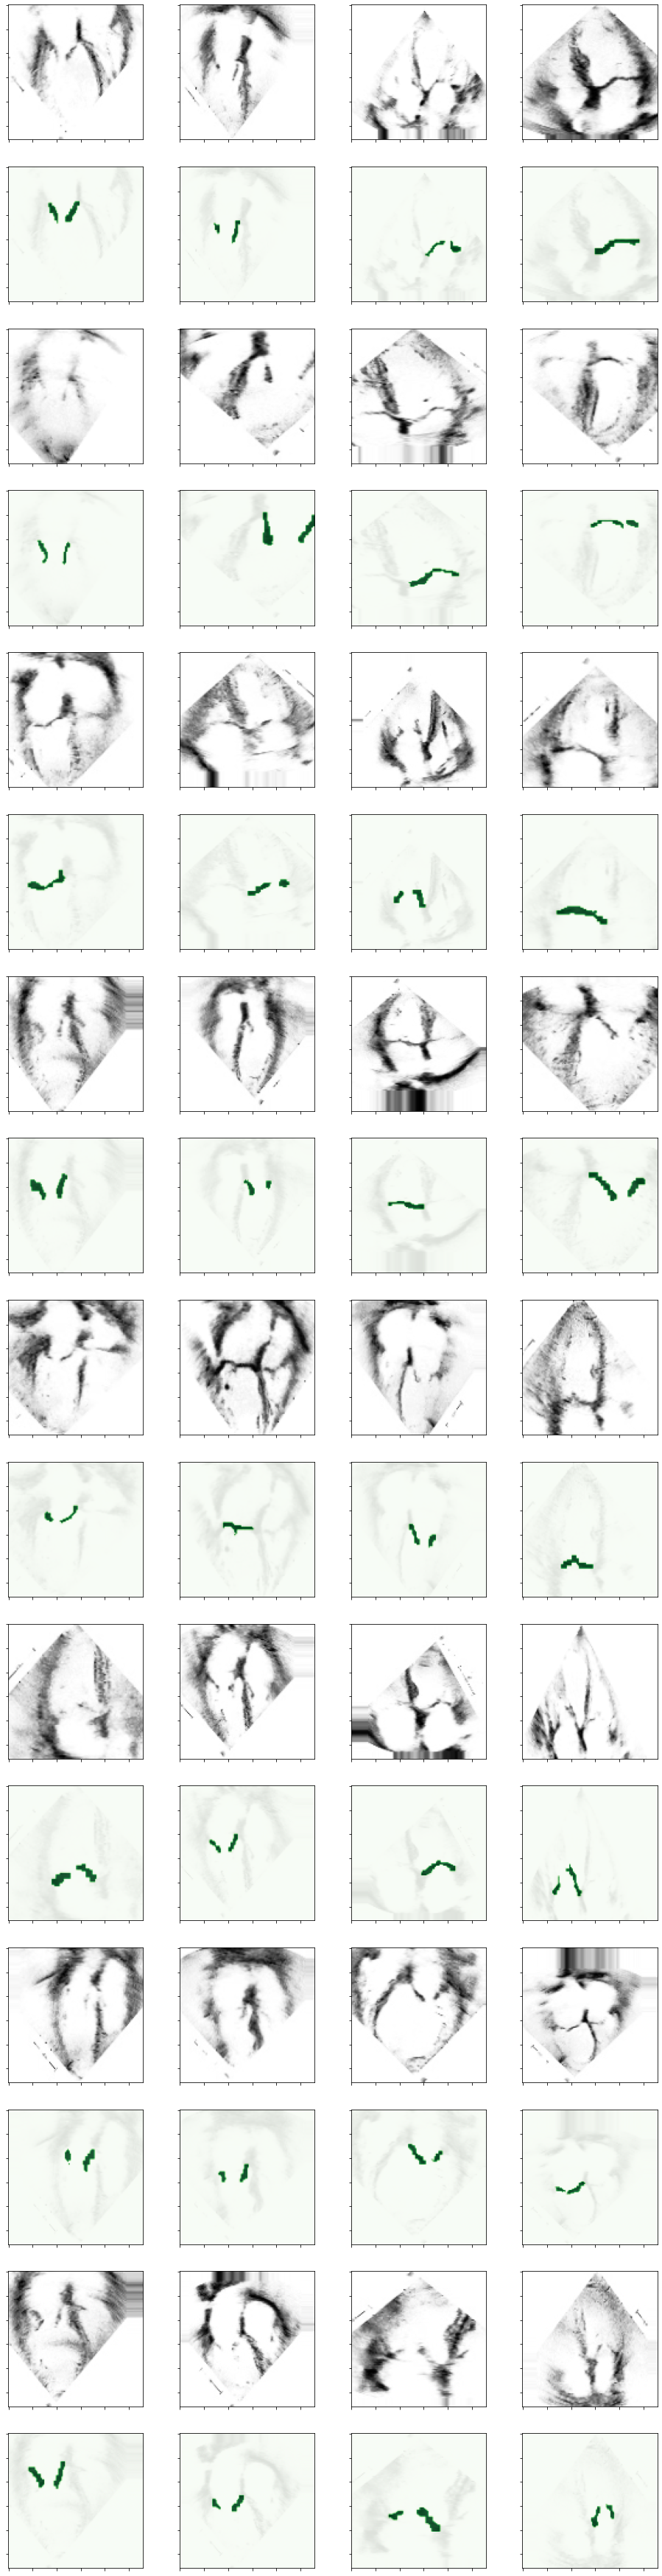

In [27]:
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for idx in range(max_images):
    img = images[idx]
    mask = masks[idx]
    ax_image = axs[int(idx / grid_width)*2, idx % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(idx / grid_width)*2+1, idx % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")    
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

In [28]:
joined_generator = val_combined_generator
images, masks = next(joined_generator)

print(len(images), len(masks))
print(images[0].shape, masks[0].shape)

8 8
(112, 112, 1) (112, 112, 1)


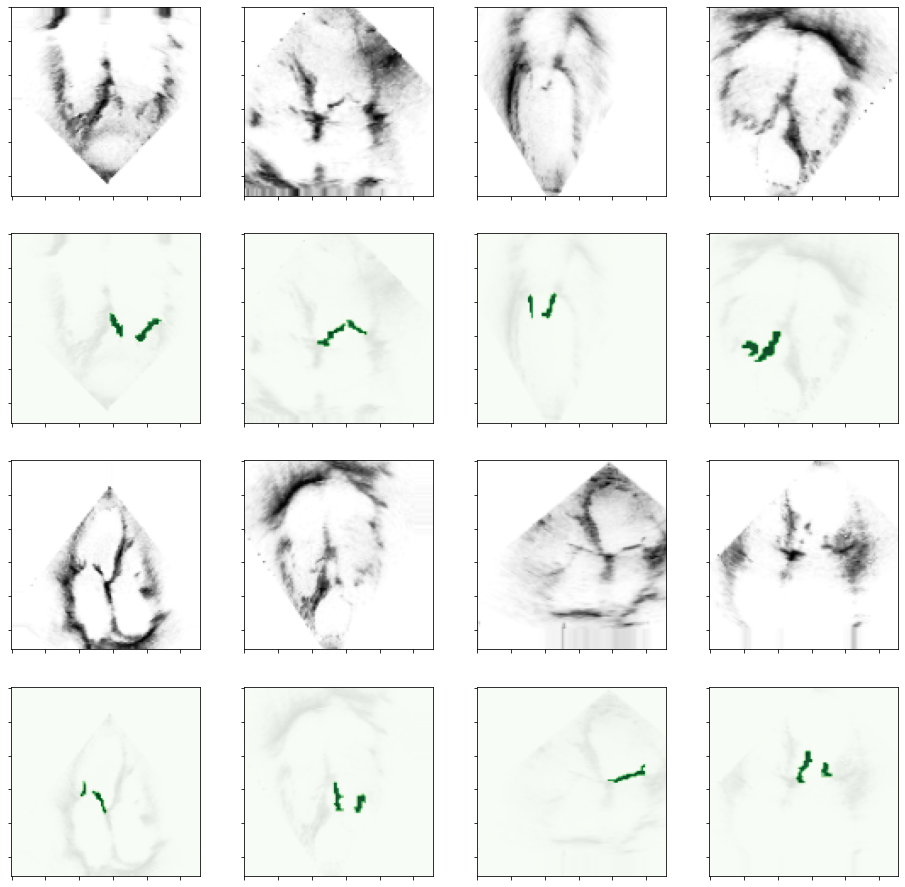

In [29]:
max_images = 8
grid_width = 4
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for idx in range(max_images):
    img = images[idx]
    mask = masks[idx]
    ax_image = axs[int(idx / grid_width)*2, idx % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(idx / grid_width)*2+1, idx % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")    
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

In [30]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [31]:
model = Model(input_layer, output_layer)

In [32]:
model.compile(loss=jaccard_loss, optimizer="adam", metrics=[jaccard_similarity, 'accuracy'])

In [34]:
epochs = 500

early_stopping = EarlyStopping(patience=25, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)

history = model.fit(train_combined_generator,
                    validation_data=val_combined_generator,
                    validation_steps=(len(X_val) + batch_size - 1) // validation_batch_size,
                    steps_per_epoch=(len(X_train) + batch_size - 1) // batch_size,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: -0.2573 - jaccard_similarity: 0.2593 - accuracy: 0.9828
Epoch 00001: val_loss improved from inf to -0.12929, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
6/6 [==============================] - 12s 2s/step - loss: -0.2573 - jaccard_similarity: 0.2593 - accuracy: 0.9828 - val_loss: -0.1293 - val_jaccard_similarity: 0.1304 - val_accuracy: 0.9712
Epoch 2/500
6/6 [==============================] - ETA: 0s - loss: -0.2517 - jaccard_similarity: 0.2603 - accuracy: 0.9841
Epoch 00002: val_loss improved from -0.12929 to -0.14232, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets
6/6 [==============================] - 11s 2s/step - loss: -0.2517 - jaccard_similarity: 0.2603 - accuracy: 0.9841 - val_loss: -0.1423 - val_jaccard_similarity: 0.1421 - val_accuracy: 0.9740
Epoch 3/500
6/6 [==============================] - ETA: 0s - loss: -0.2720 - jaccard_simi

In [35]:
predictions = []
for data in test:
    prediction = np.array(np.zeros_like(data['video']), dtype=np.bool)
    X_new = preprocess_test(data, img_size_target)
    print(len(X_new))
    for i, frame in enumerate(X_new):
        plt.show()
        pred = model.predict(frame.reshape(1,img_size_target,img_size_target))
        pred = pred > 0.1
        pred = pred * 1
        prediction[:,:,i] = cv2.resize(pred[0,:,:,0], (data['video'].shape[1], data['video'].shape[0]), interpolation = cv2.INTER_NEAREST) > 0
    predictions.append({
        'name': data['name'],
        'prediction': prediction
        }
    )

84
78
53
104
73
159
72
63
90
62
94
68
51
63
125
65
54
106
39
69


In [36]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')

# Useless cells I might use

In [ ]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [ ]:
model = Model(input_layer, output_layer)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
X, y = [], []
for data in train:
    X_new, y_new = preprocess_train(data, img_size_target)
    X += X_new
    y += y_new
X = np.array(X)
y = np.array(y)

In [ ]:
X[:-3].shape

In [ ]:
epochs = 200
batch_size = 32

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)


history = model.fit(X[:-3], y[:-3],
                    validation_data=[X[-3:], y[-3:]], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint])


In [ ]:
res = model.predict(X[-5:])
res

In [ ]:
res2 = res > 0.95
res2

In [ ]:
plt.imshow(res2[-2,:,:,0])

In [ ]:
plt.imshow(y[-2])

In [ ]:
A, B = res2[-2,:,:,0], y[-2]

In [ ]:
np.sum(np.multiply(A, B))/np.sum(A+B>0)

In [ ]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

In [ ]:
plt.imshow(X[4])

In [ ]:
plt.imshow(y[4])

In [ ]:
train_sample = train_data[41]

In [ ]:
train_sample

In [ ]:
video = train_sample['video']

In [ ]:
label = train_sample['label']

In [ ]:
video.shape

In [ ]:
# minx, miny, maxx, maxy = 1, 1, 0, 0
# for train_example in train:
#     box = train_example['box']
#     video = train_example['video']
#     h = video.shape[0]
#     w = video.shape[1]
#     x, y = np.where(box)
#     minx, miny, maxx, maxy = min(x[0]/h, minx), min(y[0]/w, miny), max(x[-1]/h, maxx), max(y[-1]/w, maxy)
# print(minx, miny, maxx, maxy)

In [ ]:
# minx, miny, maxx, maxy = 0.35, 0.45, 0.85, 0.7

In [ ]:
box = train_sample['box']

In [ ]:
np.where(box)

In [ ]:
train[-1]

In [ ]:
plt.imshow(train[-1]['video'][:,:,-1])

In [ ]:
pl

In [ ]:
train_sample['frames']

In [ ]:
np.where(label)

In [ ]:
pred = predictions[5]['prediction']
pred

In [ ]:
pred.shape

In [ ]:
plt.imshow(pred[:,:,5])

In [ ]:
test = test_data[3]
test

In [ ]:
test['video'].shape

In [ ]:
for i in range(len(y_train)):
    plt.imshow(y_train[i,:,:])
    plt.show()

In [ ]:
%matplotlib inline
import matplotlib
import ipywidgets
from PIL import Image
matplotlib.rcParams.update({'figure.max_open_warning': 0}) #avoids a warning about how many figures to keep in memory


In [ ]:
def display_simulation():
    global FIGS
    slider = ipywidgets.IntSlider(value=0,
                                  min=0,
                                  max=len(FIGS)-2)

    def figshow(i):
        return display(FIGS[i])

    ipywidgets.interact(figshow,i=slider);

In [ ]:
FIGS = [Image.fromarray(y_train[i,:,:]) for i in range(len(y_train))]

In [ ]:
display_simulation()